In [4]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from tqdm import trange, tqdm
import joblib

from pcap_processor import calculate_features



In [5]:
# Check if CUDA (NVIDIA's GPU programming toolkit) is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU.")
    print("Number of GPUs available:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. PyTorch cannot use the GPU.")

CUDA is available. PyTorch can use the GPU.
Number of GPUs available: 1
GPU Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [6]:
# Load the tensors from the .pt files
data_tensors = torch.load('data_tensors_1s_0.2s.pt')
target_tensors = torch.load('target_tensors_1s_0.2s.pt')

print("Data tensors and target tensors loaded successfully!")

# Example usage: Checking the shapes of the loaded tensors
print(f"Number of data samples: {len(data_tensors)}")
print(f"Shape of first data sample: {data_tensors[0].shape}")
print(f"Shape of target tensor: {target_tensors.shape}")

Data tensors and target tensors loaded successfully!
Number of data samples: 3000
Shape of first data sample: torch.Size([5, 22])
Shape of target tensor: torch.Size([3000])


In [7]:

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.rnn(x)
        out = self.fc(h_n[-1])
        return out


# Define custom dataset
class PacketCaptureDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]



In [8]:
# normalize the target tensors
target_mean = target_tensors.mean()
target_std = target_tensors.std()

# make a function to denormalize a prediction
def denormalize(tensor):
    return tensor * target_std + target_mean

target_tensors = (target_tensors - target_mean) / target_tensors.std()

train_data, test_data, train_targets, test_targets = train_test_split(
    data_tensors, target_tensors, test_size=0.2, random_state=42
)

# Create datasets and data loaders
train_dataset = PacketCaptureDataset(train_data, train_targets)
test_dataset = PacketCaptureDataset(test_data, test_targets)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [9]:
input_size = len(
    train_dataset[0][0][0]
)  # Assuming all packet captures have the same structure
hidden_size = 64
output_size = 1
model = RNNModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [10]:
# FILEPATH: /home/ziv/Desktop/coding/speedtest-research/cs293n/model/lstm.ipynb
# model.load_state_dict(torch.load('model_weights_10s_0.01s.pt'))

num_epochs = 1_000

model.train()
with tqdm(total=num_epochs) as pbar:
    prev_loss = float('inf')
    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1
        average_loss = total_loss / num_batches
        pbar.set_description(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
        pbar.update(1)
        
        # Check for convergence
        if abs(prev_loss - average_loss) < 1e-3:
            print("Model converged. Stopping iterations.")
            break
        
        prev_loss = average_loss



Epoch 1000, Loss: 47.6891: 100%|██████████| 1000/1000 [07:19<00:00,  2.28it/s]


In [11]:
# save the weights of the model to a file
torch.save(model.state_dict(), 'model_weights_1s_0.2s.pt')

In [12]:
total_absolute_error = 0
num_samples = len(test_targets)

for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    absolute_error = abs(predicted_value - actual_value)
    total_absolute_error += absolute_error

average_absolute_error = total_absolute_error / num_samples
print(f"Average Absolute Error: {average_absolute_error}")


Average Absolute Error: 0.34237670488587657


In [13]:
# get the average absolute error for the denormalized values
total_absolute_error = 0
num_samples = len(test_targets)

for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    absolute_error = abs(predicted_value - actual_value)
    total_absolute_error += absolute_error

average_absolute_error = total_absolute_error / num_samples
print(f"Average Absolute Error (Denormalized): {average_absolute_error}")


Average Absolute Error (Denormalized): 38.69343185424805


In [14]:
# get the median absolute error
absolute_errors = []
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    absolute_error = abs(predicted_value - actual_value)
    absolute_errors.append(absolute_error)

median_absolute_error = np.median(absolute_errors)
print(f"Median Absolute Error: {median_absolute_error}")

Median Absolute Error: 0.0952802449464798


In [15]:
# get the median absolute error for the denormalized values
absolute_errors = []
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    absolute_error = abs(predicted_value - actual_value)
    absolute_errors.append(absolute_error)

median_absolute_error = np.median(absolute_errors)
print(f"Median Absolute Error (Denormalized): {median_absolute_error}")


Median Absolute Error (Denormalized): 10.76801872253418


In [16]:
# get the mean square error
total_square_error = 0
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    square_error = (predicted_value - actual_value) ** 2
    total_square_error += square_error

mean_square_error = total_square_error / num_samples
print(f"Mean Square Error: {mean_square_error}")


Mean Square Error: 1.2738064599676522


In [17]:
# get the mean square error for the denormalized values
total_square_error = 0
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    square_error = (predicted_value - actual_value) ** 2
    total_square_error += square_error

mean_square_error = total_square_error / num_samples
print(f"Mean Square Error (Denormalized): {mean_square_error}")


Mean Square Error (Denormalized): 16269.31640625


In [18]:
# print each actual vs prediction value
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    print(f"Actual: {actual_value}, Predicted: {predicted_value}")

Actual: -0.26097801327705383, Predicted: -0.23345798254013062
Actual: -0.1850823014974594, Predicted: -0.11489653587341309
Actual: -0.25309640169143677, Predicted: -0.25848621129989624
Actual: -0.23960675299167633, Predicted: -0.13058346509933472
Actual: -0.25568556785583496, Predicted: -0.2505415678024292
Actual: -0.24677632749080658, Predicted: -0.11489653587341309
Actual: -0.17179828882217407, Predicted: -0.11489653587341309
Actual: -0.21251004934310913, Predicted: -0.16661089658737183
Actual: -0.20024289190769196, Predicted: -0.086184561252594
Actual: -0.21079477667808533, Predicted: -0.11489653587341309
Actual: -0.2349291294813156, Predicted: -0.18393319845199585
Actual: -0.23565995693206787, Predicted: -0.08000028133392334
Actual: 0.1313663125038147, Predicted: 1.6600935459136963
Actual: -0.22256030142307281, Predicted: -0.11489653587341309
Actual: -0.15978288650512695, Predicted: -0.11489653587341309
Actual: -0.07996249943971634, Predicted: -0.11489653587341309
Actual: -0.248213

In [19]:
# print each actual vs prediction value for denormalized values
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    print(f"Actual: {actual_value}, Predicted: {predicted_value}")


Actual: 0.03391075134277344, Predicted: 3.144063949584961
Actual: 8.611202239990234, Predicted: 16.543188095092773
Actual: 0.9246444702148438, Predicted: 0.3155193328857422
Actual: 2.4491653442382812, Predicted: 14.770342826843262
Actual: 0.6320323944091797, Predicted: 1.2133769989013672
Actual: 1.6389026641845703, Predicted: 16.543188095092773
Actual: 10.112483978271484, Predicted: 16.543188095092773
Actual: 5.511478424072266, Predicted: 10.698732376098633
Actual: 6.89784049987793, Predicted: 19.788047790527344
Actual: 5.705327987670898, Predicted: 16.543188095092773
Actual: 2.977804183959961, Predicted: 8.741067886352539
Actual: 2.8952102661132812, Predicted: 20.486961364746094
Actual: 44.37438201904297, Predicted: 217.14222717285156
Actual: 4.3756561279296875, Predicted: 16.543188095092773
Actual: 11.470394134521484, Predicted: 16.543188095092773
Actual: 20.491230010986328, Predicted: 16.543188095092773
Actual: 1.4764690399169922, Predicted: 16.543188095092773
Actual: 10.54359054565

In [20]:
# calculate the average percentage error of the model
total_percentage_error = 0
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    total_percentage_error += percentage_error

average_percentage_error = (total_percentage_error / num_samples) * 100
print(f"Average Percentage Error: {average_percentage_error}%")
# print the standard deviation of the percentage errors
percentage_errors = []
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors: {percentage_errors_std}")


# remove the max 2 percent of the errors and calculate the average percentage error
sorted_errors = sorted(absolute_errors)
num_samples_to_remove = int(num_samples * 0.02)
sorted_errors = sorted_errors[:-num_samples_to_remove]
average_percentage_error = (sum(sorted_errors) / len(sorted_errors)) / target_mean
print(f"Average Percentage Error (Without Top 2%): {average_percentage_error * 100}%")
# print the standard deviation of the percentage errors
percentage_errors = []
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors = percentage_errors[:-num_samples_to_remove]
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Without Top 2%): {percentage_errors_std}")


Average Percentage Error: 502.89598859307523%
Standard Deviation of Percentage Errors: 74.26676858597342
Average Percentage Error (Without Top 2%): 83.21186065673828%
Standard Deviation of Percentage Errors (Without Top 2%): 75.01802715140623


In [21]:
# calculate the average percentage error of the model for denormalized values
total_percentage_error = 0
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    total_percentage_error += percentage_error

average_percentage_error = (total_percentage_error / num_samples) * 100
print(f"Average Percentage Error (Denormalized): {average_percentage_error}%")

# print the standard deviation of the percentage errors for denormalized values
percentage_errors = []  
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Denormalized): {percentage_errors_std}")

# remove the max 2 percent of the errors and calculate the average percentage error for denormalized values
sorted_errors = sorted(absolute_errors)
num_samples_to_remove = int(num_samples * 0.02)
sorted_errors = sorted_errors[:-num_samples_to_remove]
average_percentage_error = (sum(sorted_errors) / len(sorted_errors)) / target_mean
print(f"Average Percentage Error (Without Top 2%, Denormalized): {average_percentage_error * 100}%")
# print the standard deviation of the percentage errors for denormalized values
percentage_errors = []
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors = percentage_errors[:-num_samples_to_remove]
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Without Top 2%, Denormalized): {percentage_errors_std}")



Average Percentage Error (Denormalized): 1015.664306640625%
Standard Deviation of Percentage Errors (Denormalized): 26.34423065185547
Average Percentage Error (Without Top 2%, Denormalized): 83.21186065673828%
Standard Deviation of Percentage Errors (Without Top 2%, Denormalized): 26.50909996032715


In [22]:
# calculate the median percentage error of the model
percentage_errors = []
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)
    if percentage_error < 0:
        print(f"Predicted: {predicted_value}, Actual: {actual_value}, PE: {percentage_error}")


median_percentage_error = np.median(percentage_errors) * 100
print(f"Median Percentage Error: {median_percentage_error}%")


Median Percentage Error: 45.44442422541265%


In [23]:
# calculate the median percentage error of the model for denormalized values
percentage_errors = []
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)
    if percentage_error < 0:
        print(f"Predicted: {predicted_value}, Actual: {actual_value}, PE: {percentage_error}")

median_percentage_error = np.median(percentage_errors) * 100
print(f"Median Percentage Error (Denormalized): {median_percentage_error}%")

Median Percentage Error (Denormalized): 207.49828815460205%


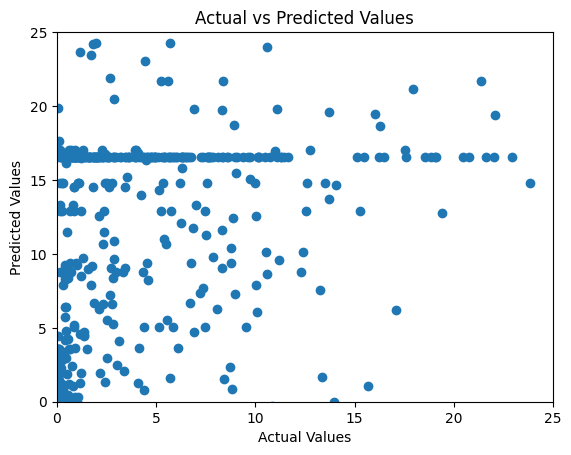

In [25]:
# plot the denormalized values for the actual and predicted values on testing set

import matplotlib.pyplot as plt

actual_values = []
predicted_values = []
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    actual_values.append(actual_value)
    predicted_values.append(predicted_value)

plt.scatter(actual_values, predicted_values)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.xlim(0, 25)
plt.ylim(0, 25)
plt.show()

